In [1]:
# 导入相关库

# PyTorch 库
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# 工具库
import numpy as np
import cv2
import random
import time
import os
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torch.autograd import Variable
import numpy as np
from math import exp
from PIL import Image

In [2]:
# SSIM损失函数实现

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [3]:
'''
Dataset for Training.
'''
class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        '''
        Ensure input and label are in couple.
        '''
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)

        
        return input, label

'''
Dataset for testing.
'''
class MyValidDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        
        return input, label

In [4]:
# 网络架构

class PReNet_r(nn.Module):
    def __init__(self, recurrent_iter=6, use_GPU=True):
        super(PReNet_r, self).__init__()
        self.iteration = recurrent_iter
        self.use_GPU = use_GPU

        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.res_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
            )


    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        #mask = Variable(torch.ones(batch_size, 3, row, col)).cuda()
        x = input
        h = Variable(torch.zeros(batch_size, 32, row, col))
        c = Variable(torch.zeros(batch_size, 32, row, col))

        if self.use_GPU:
            h = h.cuda()
            c = c.cuda()

        x_list = []
        for i in range(self.iteration):
            x = torch.cat((input, x), 1)
            x = self.conv0(x)

            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * torch.tanh(c)

            x = h
            for j in range(5):
                resx = x
                x = F.relu(self.res_conv1(x) + resx)

            x = self.conv(x)
            x = input + x
            x_list.append(x)

        return x, x_list

In [5]:
'''
Check the number of GPU.
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


Restart...


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 001/100 ] SSIM_loss = -0.86504
learning rate 0.001000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 001/100 ] SSIM_loss = -0.87126
[ Valid | 001/100 ] SSIM_loss = -0.87126 -> best
Best model found at epoch 1, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 002/100 ] SSIM_loss = -0.89210
learning rate 0.000999


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 002/100 ] SSIM_loss = -0.90039
[ Valid | 002/100 ] SSIM_loss = -0.90039 -> best
Best model found at epoch 2, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 003/100 ] SSIM_loss = -0.91068
learning rate 0.000998


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 003/100 ] SSIM_loss = -0.91558
[ Valid | 003/100 ] SSIM_loss = -0.91558 -> best
Best model found at epoch 3, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 004/100 ] SSIM_loss = -0.92099
learning rate 0.000996


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 004/100 ] SSIM_loss = -0.91506
[ Valid | 004/100 ] SSIM_loss = -0.91506


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 005/100 ] SSIM_loss = -0.92645
learning rate 0.000994


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 005/100 ] SSIM_loss = -0.93010
[ Valid | 005/100 ] SSIM_loss = -0.93010 -> best
Best model found at epoch 5, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 006/100 ] SSIM_loss = -0.93072
learning rate 0.000991


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 006/100 ] SSIM_loss = -0.92597
[ Valid | 006/100 ] SSIM_loss = -0.92597


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 007/100 ] SSIM_loss = -0.93227
learning rate 0.000988


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 007/100 ] SSIM_loss = -0.93230
[ Valid | 007/100 ] SSIM_loss = -0.93230 -> best
Best model found at epoch 7, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 008/100 ] SSIM_loss = -0.93856
learning rate 0.000984


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 008/100 ] SSIM_loss = -0.92888
[ Valid | 008/100 ] SSIM_loss = -0.92888


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 009/100 ] SSIM_loss = -0.93979
learning rate 0.000980


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 009/100 ] SSIM_loss = -0.93512
[ Valid | 009/100 ] SSIM_loss = -0.93512 -> best
Best model found at epoch 9, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 010/100 ] SSIM_loss = -0.94334
learning rate 0.000976


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 010/100 ] SSIM_loss = -0.93511
[ Valid | 010/100 ] SSIM_loss = -0.93511


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 011/100 ] SSIM_loss = -0.94515
learning rate 0.000970


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 011/100 ] SSIM_loss = -0.94259
[ Valid | 011/100 ] SSIM_loss = -0.94259 -> best
Best model found at epoch 11, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 012/100 ] SSIM_loss = -0.94566
learning rate 0.000965


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 012/100 ] SSIM_loss = -0.94522
[ Valid | 012/100 ] SSIM_loss = -0.94522 -> best
Best model found at epoch 12, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 013/100 ] SSIM_loss = -0.94803
learning rate 0.000959


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 013/100 ] SSIM_loss = -0.94394
[ Valid | 013/100 ] SSIM_loss = -0.94394


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 014/100 ] SSIM_loss = -0.94612
learning rate 0.000952


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 014/100 ] SSIM_loss = -0.94631
[ Valid | 014/100 ] SSIM_loss = -0.94631 -> best
Best model found at epoch 14, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 015/100 ] SSIM_loss = -0.94949
learning rate 0.000946


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 015/100 ] SSIM_loss = -0.94547
[ Valid | 015/100 ] SSIM_loss = -0.94547


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 016/100 ] SSIM_loss = -0.95168
learning rate 0.000938


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 016/100 ] SSIM_loss = -0.94774
[ Valid | 016/100 ] SSIM_loss = -0.94774 -> best
Best model found at epoch 16, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 017/100 ] SSIM_loss = -0.95275
learning rate 0.000930


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 017/100 ] SSIM_loss = -0.93976
[ Valid | 017/100 ] SSIM_loss = -0.93976


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 018/100 ] SSIM_loss = -0.94778
learning rate 0.000922


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 018/100 ] SSIM_loss = -0.93559
[ Valid | 018/100 ] SSIM_loss = -0.93559


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 019/100 ] SSIM_loss = -0.95384
learning rate 0.000914


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 019/100 ] SSIM_loss = -0.94397
[ Valid | 019/100 ] SSIM_loss = -0.94397


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 020/100 ] SSIM_loss = -0.95264
learning rate 0.000905


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 020/100 ] SSIM_loss = -0.94902
[ Valid | 020/100 ] SSIM_loss = -0.94902 -> best
Best model found at epoch 20, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 021/100 ] SSIM_loss = -0.95485
learning rate 0.000895


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 021/100 ] SSIM_loss = -0.94894
[ Valid | 021/100 ] SSIM_loss = -0.94894


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 022/100 ] SSIM_loss = -0.95505
learning rate 0.000885


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 022/100 ] SSIM_loss = -0.95027
[ Valid | 022/100 ] SSIM_loss = -0.95027 -> best
Best model found at epoch 22, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 023/100 ] SSIM_loss = -0.95551
learning rate 0.000875


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 023/100 ] SSIM_loss = -0.95018
[ Valid | 023/100 ] SSIM_loss = -0.95018


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 024/100 ] SSIM_loss = -0.95665
learning rate 0.000864


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 024/100 ] SSIM_loss = -0.95278
[ Valid | 024/100 ] SSIM_loss = -0.95278 -> best
Best model found at epoch 24, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 025/100 ] SSIM_loss = -0.95823
learning rate 0.000854


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 025/100 ] SSIM_loss = -0.94800
[ Valid | 025/100 ] SSIM_loss = -0.94800


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 026/100 ] SSIM_loss = -0.95613
learning rate 0.000842


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 026/100 ] SSIM_loss = -0.94993
[ Valid | 026/100 ] SSIM_loss = -0.94993


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 027/100 ] SSIM_loss = -0.95708
learning rate 0.000831


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 027/100 ] SSIM_loss = -0.95369
[ Valid | 027/100 ] SSIM_loss = -0.95369 -> best
Best model found at epoch 27, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 028/100 ] SSIM_loss = -0.95911
learning rate 0.000819


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 028/100 ] SSIM_loss = -0.95281
[ Valid | 028/100 ] SSIM_loss = -0.95281


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 029/100 ] SSIM_loss = -0.95977
learning rate 0.000806


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 029/100 ] SSIM_loss = -0.95231
[ Valid | 029/100 ] SSIM_loss = -0.95231


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 030/100 ] SSIM_loss = -0.96020
learning rate 0.000794


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 030/100 ] SSIM_loss = -0.95382
[ Valid | 030/100 ] SSIM_loss = -0.95382 -> best
Best model found at epoch 30, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 031/100 ] SSIM_loss = -0.95941
learning rate 0.000781


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 031/100 ] SSIM_loss = -0.94790
[ Valid | 031/100 ] SSIM_loss = -0.94790


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 032/100 ] SSIM_loss = -0.95978
learning rate 0.000768


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 032/100 ] SSIM_loss = -0.95550
[ Valid | 032/100 ] SSIM_loss = -0.95550 -> best
Best model found at epoch 32, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 033/100 ] SSIM_loss = -0.96121
learning rate 0.000755


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 033/100 ] SSIM_loss = -0.95496
[ Valid | 033/100 ] SSIM_loss = -0.95496


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 034/100 ] SSIM_loss = -0.96222
learning rate 0.000741


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 034/100 ] SSIM_loss = -0.95720
[ Valid | 034/100 ] SSIM_loss = -0.95720 -> best
Best model found at epoch 34, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 035/100 ] SSIM_loss = -0.96164
learning rate 0.000727


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 035/100 ] SSIM_loss = -0.94717
[ Valid | 035/100 ] SSIM_loss = -0.94717


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 036/100 ] SSIM_loss = -0.96213
learning rate 0.000713


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 036/100 ] SSIM_loss = -0.94913
[ Valid | 036/100 ] SSIM_loss = -0.94913


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 037/100 ] SSIM_loss = -0.96000
learning rate 0.000699


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 037/100 ] SSIM_loss = -0.94861
[ Valid | 037/100 ] SSIM_loss = -0.94861


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 038/100 ] SSIM_loss = -0.96047
learning rate 0.000684


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 038/100 ] SSIM_loss = -0.95717
[ Valid | 038/100 ] SSIM_loss = -0.95717


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 039/100 ] SSIM_loss = -0.96304
learning rate 0.000669


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 039/100 ] SSIM_loss = -0.95794
[ Valid | 039/100 ] SSIM_loss = -0.95794 -> best
Best model found at epoch 39, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 040/100 ] SSIM_loss = -0.96277
learning rate 0.000655


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 040/100 ] SSIM_loss = -0.95613
[ Valid | 040/100 ] SSIM_loss = -0.95613


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 041/100 ] SSIM_loss = -0.96410
learning rate 0.000639


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 041/100 ] SSIM_loss = -0.94940
[ Valid | 041/100 ] SSIM_loss = -0.94940


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 042/100 ] SSIM_loss = -0.96258
learning rate 0.000624


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 042/100 ] SSIM_loss = -0.95820
[ Valid | 042/100 ] SSIM_loss = -0.95820 -> best
Best model found at epoch 42, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 043/100 ] SSIM_loss = -0.96231
learning rate 0.000609


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 043/100 ] SSIM_loss = -0.95653
[ Valid | 043/100 ] SSIM_loss = -0.95653


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 044/100 ] SSIM_loss = -0.96402
learning rate 0.000594


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 044/100 ] SSIM_loss = -0.95521
[ Valid | 044/100 ] SSIM_loss = -0.95521


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 045/100 ] SSIM_loss = -0.96326
learning rate 0.000578


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 045/100 ] SSIM_loss = -0.94849
[ Valid | 045/100 ] SSIM_loss = -0.94849


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 046/100 ] SSIM_loss = -0.96486
learning rate 0.000563


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 046/100 ] SSIM_loss = -0.95765
[ Valid | 046/100 ] SSIM_loss = -0.95765


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 047/100 ] SSIM_loss = -0.96522
learning rate 0.000547


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 047/100 ] SSIM_loss = -0.94335
[ Valid | 047/100 ] SSIM_loss = -0.94335


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 048/100 ] SSIM_loss = -0.96372
learning rate 0.000531


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 048/100 ] SSIM_loss = -0.95930
[ Valid | 048/100 ] SSIM_loss = -0.95930 -> best
Best model found at epoch 48, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 049/100 ] SSIM_loss = -0.96578
learning rate 0.000516


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 049/100 ] SSIM_loss = -0.95952
[ Valid | 049/100 ] SSIM_loss = -0.95952 -> best
Best model found at epoch 49, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 050/100 ] SSIM_loss = -0.96603
learning rate 0.000500


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 050/100 ] SSIM_loss = -0.95802
[ Valid | 050/100 ] SSIM_loss = -0.95802


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 051/100 ] SSIM_loss = -0.96593
learning rate 0.000484


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 051/100 ] SSIM_loss = -0.95588
[ Valid | 051/100 ] SSIM_loss = -0.95588


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 052/100 ] SSIM_loss = -0.96555
learning rate 0.000469


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 052/100 ] SSIM_loss = -0.95765
[ Valid | 052/100 ] SSIM_loss = -0.95765


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 053/100 ] SSIM_loss = -0.96638
learning rate 0.000453


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 053/100 ] SSIM_loss = -0.95632
[ Valid | 053/100 ] SSIM_loss = -0.95632


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 054/100 ] SSIM_loss = -0.96682
learning rate 0.000437


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 054/100 ] SSIM_loss = -0.95556
[ Valid | 054/100 ] SSIM_loss = -0.95556


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 055/100 ] SSIM_loss = -0.96675
learning rate 0.000422


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 055/100 ] SSIM_loss = -0.95845
[ Valid | 055/100 ] SSIM_loss = -0.95845


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 056/100 ] SSIM_loss = -0.96703
learning rate 0.000406


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 056/100 ] SSIM_loss = -0.95966
[ Valid | 056/100 ] SSIM_loss = -0.95966 -> best
Best model found at epoch 56, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 057/100 ] SSIM_loss = -0.96714
learning rate 0.000391


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 057/100 ] SSIM_loss = -0.95826
[ Valid | 057/100 ] SSIM_loss = -0.95826


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 058/100 ] SSIM_loss = -0.96710
learning rate 0.000376


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 058/100 ] SSIM_loss = -0.95452
[ Valid | 058/100 ] SSIM_loss = -0.95452


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 059/100 ] SSIM_loss = -0.96706
learning rate 0.000361


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 059/100 ] SSIM_loss = -0.95862
[ Valid | 059/100 ] SSIM_loss = -0.95862


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 060/100 ] SSIM_loss = -0.96778
learning rate 0.000345


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 060/100 ] SSIM_loss = -0.95819
[ Valid | 060/100 ] SSIM_loss = -0.95819


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 061/100 ] SSIM_loss = -0.96843
learning rate 0.000331


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 061/100 ] SSIM_loss = -0.95379
[ Valid | 061/100 ] SSIM_loss = -0.95379


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 062/100 ] SSIM_loss = -0.96842
learning rate 0.000316


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 062/100 ] SSIM_loss = -0.95833
[ Valid | 062/100 ] SSIM_loss = -0.95833


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 063/100 ] SSIM_loss = -0.96798
learning rate 0.000301


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 063/100 ] SSIM_loss = -0.95413
[ Valid | 063/100 ] SSIM_loss = -0.95413


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 064/100 ] SSIM_loss = -0.96812
learning rate 0.000287


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 064/100 ] SSIM_loss = -0.95462
[ Valid | 064/100 ] SSIM_loss = -0.95462


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 065/100 ] SSIM_loss = -0.96843
learning rate 0.000273


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 065/100 ] SSIM_loss = -0.94877
[ Valid | 065/100 ] SSIM_loss = -0.94877


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 066/100 ] SSIM_loss = -0.96872
learning rate 0.000259


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 066/100 ] SSIM_loss = -0.96083
[ Valid | 066/100 ] SSIM_loss = -0.96083 -> best
Best model found at epoch 66, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 067/100 ] SSIM_loss = -0.96898
learning rate 0.000245


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 067/100 ] SSIM_loss = -0.95762
[ Valid | 067/100 ] SSIM_loss = -0.95762


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 068/100 ] SSIM_loss = -0.96922
learning rate 0.000232


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 068/100 ] SSIM_loss = -0.95799
[ Valid | 068/100 ] SSIM_loss = -0.95799


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 069/100 ] SSIM_loss = -0.96946
learning rate 0.000219


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 069/100 ] SSIM_loss = -0.95788
[ Valid | 069/100 ] SSIM_loss = -0.95788


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 070/100 ] SSIM_loss = -0.96928
learning rate 0.000206


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 070/100 ] SSIM_loss = -0.96013
[ Valid | 070/100 ] SSIM_loss = -0.96013


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 071/100 ] SSIM_loss = -0.96957
learning rate 0.000194


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 071/100 ] SSIM_loss = -0.95837
[ Valid | 071/100 ] SSIM_loss = -0.95837


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 072/100 ] SSIM_loss = -0.96938
learning rate 0.000181


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 072/100 ] SSIM_loss = -0.95919
[ Valid | 072/100 ] SSIM_loss = -0.95919


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 073/100 ] SSIM_loss = -0.96936
learning rate 0.000169


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 073/100 ] SSIM_loss = -0.96129
[ Valid | 073/100 ] SSIM_loss = -0.96129 -> best
Best model found at epoch 73, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 074/100 ] SSIM_loss = -0.96987
learning rate 0.000158


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 074/100 ] SSIM_loss = -0.96004
[ Valid | 074/100 ] SSIM_loss = -0.96004


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 075/100 ] SSIM_loss = -0.96996
learning rate 0.000146


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 075/100 ] SSIM_loss = -0.95596
[ Valid | 075/100 ] SSIM_loss = -0.95596


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 076/100 ] SSIM_loss = -0.97009
learning rate 0.000136


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 076/100 ] SSIM_loss = -0.95800
[ Valid | 076/100 ] SSIM_loss = -0.95800


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 077/100 ] SSIM_loss = -0.97026
learning rate 0.000125


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 077/100 ] SSIM_loss = -0.94800
[ Valid | 077/100 ] SSIM_loss = -0.94800


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 078/100 ] SSIM_loss = -0.97030
learning rate 0.000115


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 078/100 ] SSIM_loss = -0.95880
[ Valid | 078/100 ] SSIM_loss = -0.95880


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 079/100 ] SSIM_loss = -0.97037
learning rate 0.000105


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 079/100 ] SSIM_loss = -0.95741
[ Valid | 079/100 ] SSIM_loss = -0.95741


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 080/100 ] SSIM_loss = -0.97056
learning rate 0.000095


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 080/100 ] SSIM_loss = -0.95655
[ Valid | 080/100 ] SSIM_loss = -0.95655


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 081/100 ] SSIM_loss = -0.97044
learning rate 0.000086


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 081/100 ] SSIM_loss = -0.95846
[ Valid | 081/100 ] SSIM_loss = -0.95846


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 082/100 ] SSIM_loss = -0.97072
learning rate 0.000078


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 082/100 ] SSIM_loss = -0.95678
[ Valid | 082/100 ] SSIM_loss = -0.95678


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 083/100 ] SSIM_loss = -0.97047
learning rate 0.000070


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 083/100 ] SSIM_loss = -0.95897
[ Valid | 083/100 ] SSIM_loss = -0.95897


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 084/100 ] SSIM_loss = -0.97073
learning rate 0.000062


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 084/100 ] SSIM_loss = -0.95881
[ Valid | 084/100 ] SSIM_loss = -0.95881


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 085/100 ] SSIM_loss = -0.97061
learning rate 0.000054


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 085/100 ] SSIM_loss = -0.95770
[ Valid | 085/100 ] SSIM_loss = -0.95770


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 086/100 ] SSIM_loss = -0.97062
learning rate 0.000048


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 086/100 ] SSIM_loss = -0.95719
[ Valid | 086/100 ] SSIM_loss = -0.95719


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 087/100 ] SSIM_loss = -0.97082
learning rate 0.000041


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 087/100 ] SSIM_loss = -0.95894
[ Valid | 087/100 ] SSIM_loss = -0.95894


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 088/100 ] SSIM_loss = -0.97091
learning rate 0.000035


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 088/100 ] SSIM_loss = -0.95686
[ Valid | 088/100 ] SSIM_loss = -0.95686


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 089/100 ] SSIM_loss = -0.97096
learning rate 0.000030


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 089/100 ] SSIM_loss = -0.95948
[ Valid | 089/100 ] SSIM_loss = -0.95948


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 090/100 ] SSIM_loss = -0.97092
learning rate 0.000024


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 090/100 ] SSIM_loss = -0.95961
[ Valid | 090/100 ] SSIM_loss = -0.95961


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 091/100 ] SSIM_loss = -0.97096
learning rate 0.000020


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 091/100 ] SSIM_loss = -0.95857
[ Valid | 091/100 ] SSIM_loss = -0.95857


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 092/100 ] SSIM_loss = -0.97118
learning rate 0.000016


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 092/100 ] SSIM_loss = -0.95885
[ Valid | 092/100 ] SSIM_loss = -0.95885


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 093/100 ] SSIM_loss = -0.97117
learning rate 0.000012


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 093/100 ] SSIM_loss = -0.95815
[ Valid | 093/100 ] SSIM_loss = -0.95815


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 094/100 ] SSIM_loss = -0.97107
learning rate 0.000009


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 094/100 ] SSIM_loss = -0.95447
[ Valid | 094/100 ] SSIM_loss = -0.95447


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 095/100 ] SSIM_loss = -0.97110
learning rate 0.000006


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 095/100 ] SSIM_loss = -0.95864
[ Valid | 095/100 ] SSIM_loss = -0.95864


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 096/100 ] SSIM_loss = -0.97119
learning rate 0.000004


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 096/100 ] SSIM_loss = -0.95624
[ Valid | 096/100 ] SSIM_loss = -0.95624


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 097/100 ] SSIM_loss = -0.97117
learning rate 0.000002


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 097/100 ] SSIM_loss = -0.95907
[ Valid | 097/100 ] SSIM_loss = -0.95907


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 098/100 ] SSIM_loss = -0.97125
learning rate 0.000001


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 098/100 ] SSIM_loss = -0.95579
[ Valid | 098/100 ] SSIM_loss = -0.95579


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 099/100 ] SSIM_loss = -0.97128
learning rate 0.000000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 099/100 ] SSIM_loss = -0.95856
[ Valid | 099/100 ] SSIM_loss = -0.95856


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 100/100 ] SSIM_loss = -0.97121
learning rate 0.000000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 100/100 ] SSIM_loss = -0.95603
[ Valid | 100/100 ] SSIM_loss = -0.95603


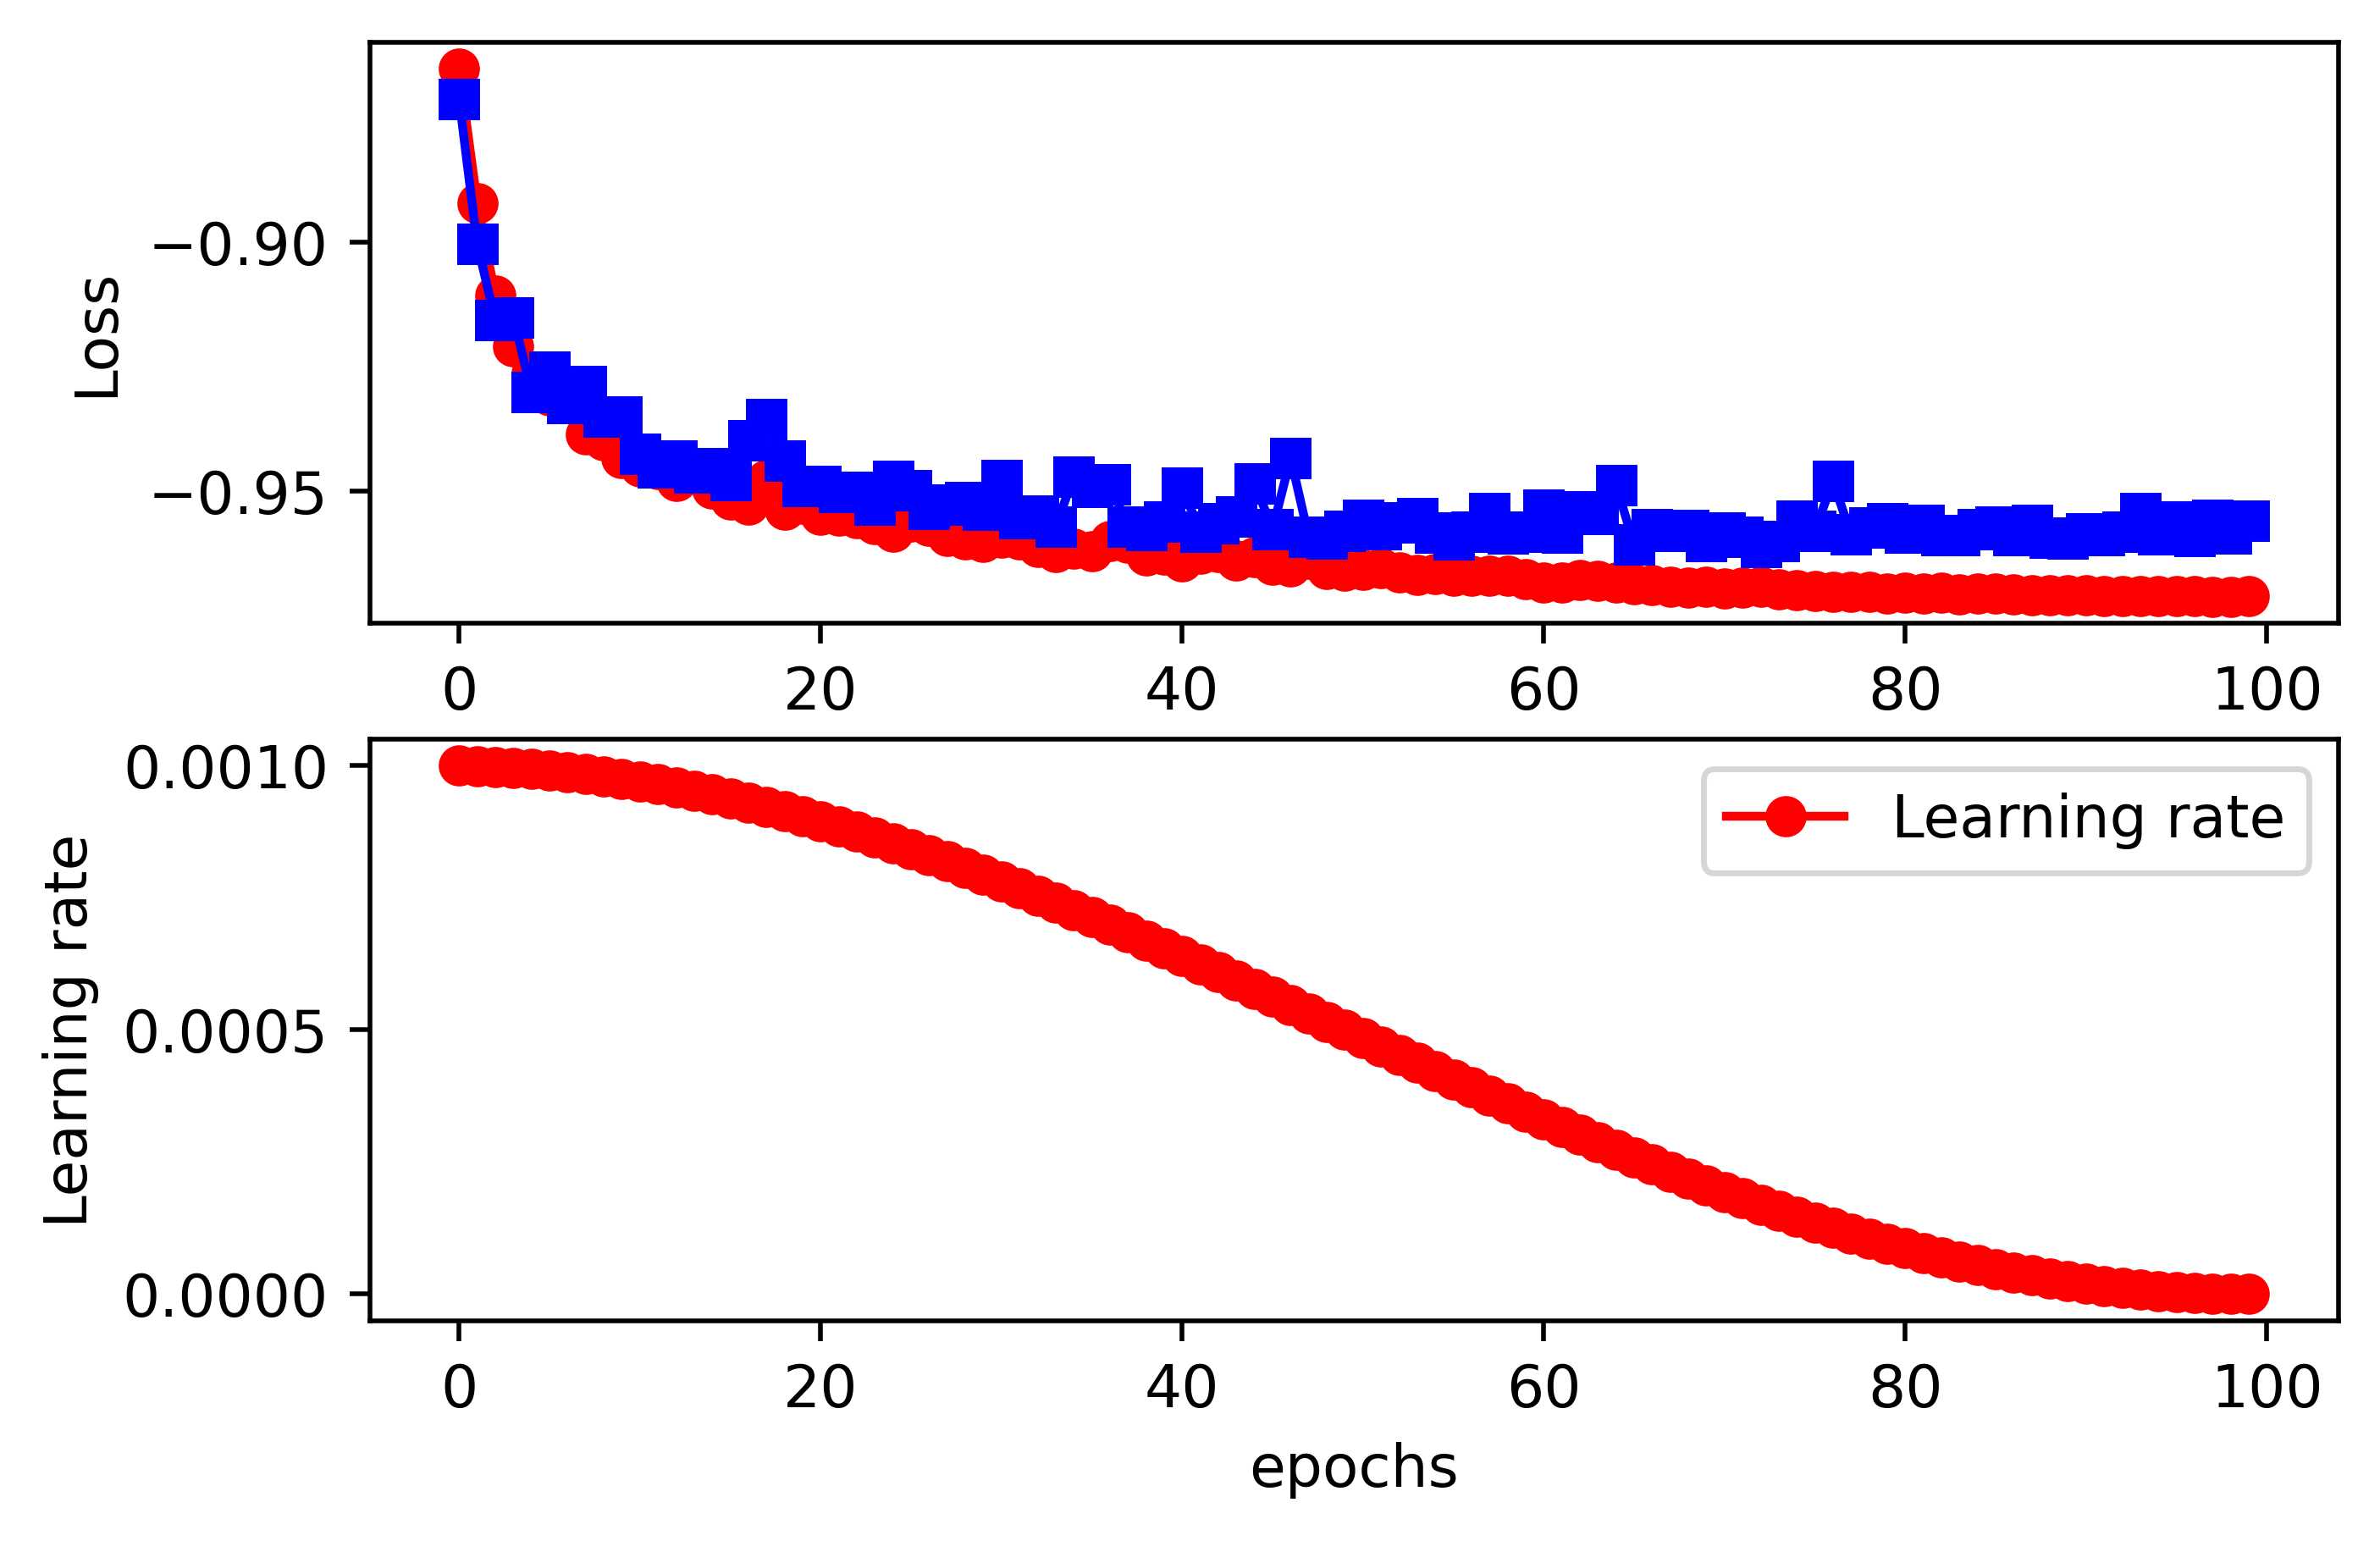

In [6]:
'''
Path of Dataset.
'''
input_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/rain"
label_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/norain"
valid_input_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/rain/X2'
valid_label_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/norain'

'''
Check the device.
'''
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

'''
Move the Network to the CUDA.
'''
net = PReNet_r().to(device)

'''
Hyper Parameters.
    TODO: fine-tuning.
'''
learning_rate = 1e-3
batch_size = 32
epoch = 100
patience = 300
stale = 0
best_valid_loss = 10000
break_point = 0

'''
Prepare for plt.
'''
Loss_list = []
Valid_Loss_list = []
learning_rate_list = []

'''
Define optimizer and Loss Function.
'''
optimizer = optim.RAdam(net.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

loss_f = SSIM()

'''
Check the model.
'''
if os.path.exists('./model.pth'): 
    print('Continue train with last model...')
    net.load_state_dict(torch.load('./model.pth'))
else: 
    print("Restart...")

'''
Prepare DataLoaders.

Attension:
    'pin_numbers=True' can accelorate CUDA computing.
'''
dataset_train = MyTrainDataset(input_path, label_path)
dataset_valid = MyValidDataset(valid_input_path, valid_label_path)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)

'''
START Training ...
'''
for i in range(epoch):
# ---------------Train----------------
    net.train()
    train_losses = []
    
    '''
    tqdm is a toolkit for progress bar.
    '''
    for batch in tqdm(train_loader):
        inputs, labels = batch
        
        outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        optimizer.zero_grad()
        
        loss.backward()
        
        '''
        Avoid grad to be too BIG.
        '''
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        
        optimizer.step()
        
        '''
        Attension:
            We need set 'loss.item()' to turn Tensor into Numpy, or plt will not work.
        '''
        train_losses.append(loss.item())
        
    train_loss = sum(train_losses) / len(train_losses)
    Loss_list.append(train_loss)
    print(f"[ Train | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {train_loss:.5f}")
    
    scheduler.step()
    for param_group in optimizer.param_groups:
        learning_rate_list.append(param_group["lr"])
        print('learning rate %f' % param_group["lr"])
    
# -------------Validation-------------
    '''
    Validation is a step to ensure training process is working.
    You can also exploit Validation to see if your net work is overfitting.
    
    Firstly, you should set model.eval(), to ensure parameters not training.
    '''
    net.eval()
    valid_losses = []
    for batch in tqdm(valid_loader):
        inputs, labels = batch
        
        '''
        Cancel gradient decent.
        '''
        with torch.no_grad():
            outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        valid_losses.append(loss.item())
    
    valid_loss = sum(valid_losses) / len(valid_losses)
    Valid_Loss_list.append(valid_loss)
    print(f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    break_point = i + 1
    
    '''
    Update Logs and save the best model.
    Patience is also checked.
        
    '''
    if valid_loss < best_valid_loss:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f} -> best")
    else:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    if valid_loss < best_valid_loss:
        print(f'Best model found at epoch {i+1}, saving model')
        torch.save(net.state_dict(), f'model_best.ckpt')
        best_valid_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvement {patience} consecutive epochs, early stopping.')
            break

'''
Use plt to draw Loss curves.
'''
plt.figure(dpi=500)

plt.subplot(211)
x = range(break_point)
y = Loss_list
plt.plot(x, y, 'ro-', label='Train Loss')
plt.plot(range(break_point), Valid_Loss_list, 'bs-', label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')

plt.subplot(212)
plt.plot(x, learning_rate_list, 'ro-', label='Learning rate')
plt.ylabel('Learning rate')
plt.xlabel('epochs')

plt.legend()
plt.show()